In [1]:
# imports
import pandas as pd                              # it's pandas
import Constants as c                           # constants
import Functions as f                           # plotting functions
import matplotlib.pyplot as plt
import numpy as np
import plotly.offline as po
import pickle
from math import radians


In [2]:
# Import dataframe from "out" folder
with open('../out/TREAD_out.pkl', 'rb') as file:
    df, trips_list, name_of_route = pickle.load(file)
# pick one random trip to fiddle with it
#sample_trip = trips_list[73]
sample_trip = trips_list[1]
display(f"There are in total {df['trip_id'].max() + 1} separate trips")

'There are in total 45384 separate trips'

In [3]:
# some info about the dataframe
sample_trip.reset_index(inplace=True, drop=True)
# the above instruction sometimes adds a new column called 'index', which is subsequently removed
if 'index' in sample_trip.columns:
    print("Column \"Index\" removed")
    sample_trip.drop(['index'], axis=1, inplace=True)
display(sample_trip.head(3))
#display(df)
# current columns (aka features) of the dataset
print(df.columns)
display(df.info())

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,VesselType,Status,...,Draft,IsClassA,Avg_Speed,EstimatedStatus,IsInWP,IsInSignificantWP,Route,IsInRoute,group,trip_id
0,303174000,2019-02-20 18:55:58,21.3100,-157.8744,7.5,124.9,511.0,GAIL ANN,30,99,...,NaN,False,3.98,sailing,WP_152,<NA>,WP_152 - WP_120,True,1,1316
1,303174000,2019-02-20 18:56:59,21.3086,-157.8727,7.6,135.1,511.0,GAIL ANN,30,99,...,NaN,False,7.50,sailing,WP_152,<NA>,WP_152 - WP_120,True,0,1316
2,303174000,2019-02-20 18:59:33,21.3042,-157.8693,7.6,149.9,511.0,GAIL ANN,30,99,...,NaN,False,7.62,sailing,WP_152,<NA>,WP_152 - WP_120,True,0,1316


Index(['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading',
       'VesselName', 'VesselType', 'Status', 'Length', 'Width', 'Draft',
       'IsClassA', 'Avg_Speed', 'EstimatedStatus', 'IsInWP',
       'IsInSignificantWP', 'Route', 'IsInRoute', 'group', 'trip_id'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 5460702 entries, 0 to 2
Data columns (total 22 columns):
 #   Column             Dtype        
---  ------             -----        
 0   MMSI               int32        
 1   BaseDateTime       datetime64[s]
 2   LAT                float64      
 3   LON                float64      
 4   SOG                float64      
 5   COG                float64      
 6   Heading            float64      
 7   VesselName         string       
 8   VesselType         int16        
 9   Status             int8         
 10  Length             int16        
 11  Width              int16        
 12  Draft              float32      
 13  IsClassA           bool   

None

#### General Approach
1. Normalization (some features have different scales) (to be decided, probably not)
2. Features selection
3. Algorithm

In [4]:
# check which columns contain any null values
df.isnull().sum()

MMSI                       0
BaseDateTime               0
LAT                        0
LON                        0
SOG                        0
COG                        0
Heading                    0
VesselName            456248
VesselType                 0
Status                     0
Length                     0
Width                      0
Draft                3618047
IsClassA                   0
Avg_Speed                  0
EstimatedStatus            0
IsInWP               1278778
IsInSignificantWP    1734711
Route                      0
IsInRoute                  0
group                      0
trip_id                    0
dtype: int64

In [5]:
# all the trips of the chosen route are separated in a list
# create a single dataframe with all of them together
myDF = pd.concat(trips_list, ignore_index=True, axis=0)
display(myDF.head())

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,VesselType,Status,...,Draft,IsClassA,Avg_Speed,EstimatedStatus,IsInWP,IsInSignificantWP,Route,IsInRoute,group,trip_id
0,245011000,2019-01-07 14:44:39,21.3013,-157.8668,1.4,337.0,35.0,PRINS HENDRIK,80,5,...,9.4,True,0.83,sailing,WP_152,<NA>,WP_152 - WP_120,True,1,422
1,245011000,2019-01-07 14:49:18,21.3032,-157.8673,0.8,70.0,169.0,PRINS HENDRIK,80,0,...,9.4,True,1.52,sailing,WP_152,<NA>,WP_152 - WP_120,True,0,422
2,245011000,2019-01-07 14:51:08,21.3028,-157.8673,2.2,198.0,197.0,PRINS HENDRIK,80,0,...,9.4,True,0.79,sailing,WP_152,<NA>,WP_152 - WP_120,True,0,422
3,245011000,2019-01-07 14:52:38,21.3013,-157.8678,4.3,201.0,206.0,PRINS HENDRIK,80,0,...,9.4,True,3.78,sailing,WP_152,<NA>,WP_152 - WP_120,True,0,422
4,245011000,2019-01-07 14:53:48,21.3000,-157.8685,5.2,208.0,208.0,PRINS HENDRIK,80,0,...,9.4,True,4.50,sailing,WP_152,<NA>,WP_152 - WP_120,True,0,422


,trip_id,count
0,31456,524
1,10795,294
2,17167,267
3,17097,267
4,25364,233
...,...,...
182,25247,64
183,22400,64
184,25022,59
185,10809,55


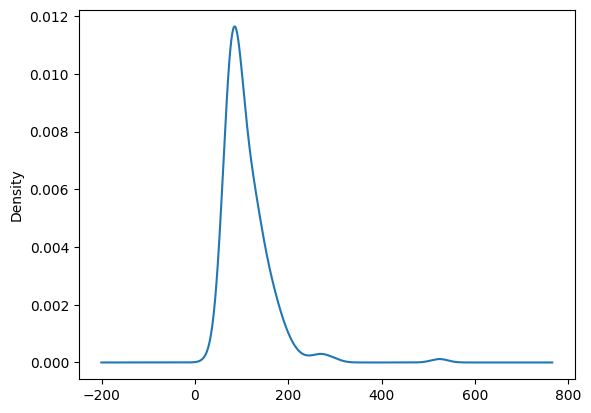

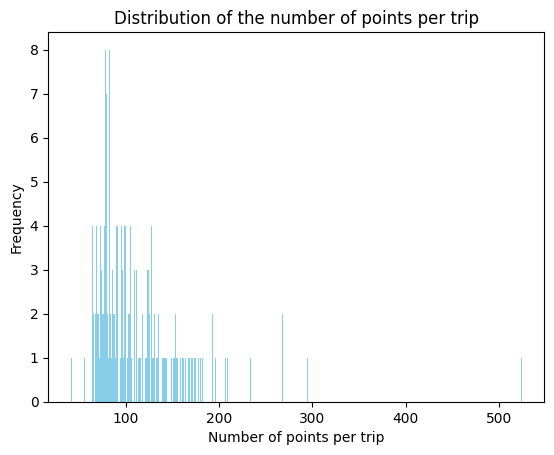

In [6]:
# for each trip_id, extract how many points where generated
points_per_trip = myDF['trip_id'].value_counts().reset_index(name='count')

display(points_per_trip)

# plot the kde approximation of the distribution of the amount of points per trip
points_per_trip["count"].plot(kind="kde")
# plot a more precise histogram of the same distribution
plt.figure()
plt.hist(points_per_trip['count'], 
         bins=range(min(points_per_trip['count']), max(points_per_trip['count']) + 1, 1), # from, to, step
         color='skyblue')
plt.xlabel('Number of points per trip')
plt.ylabel('Frequency')
plt.title('Distribution of the number of points per trip')
plt.show()

Text(0.5, 1.0, 'Fit Values: 71.92 and 7.15')

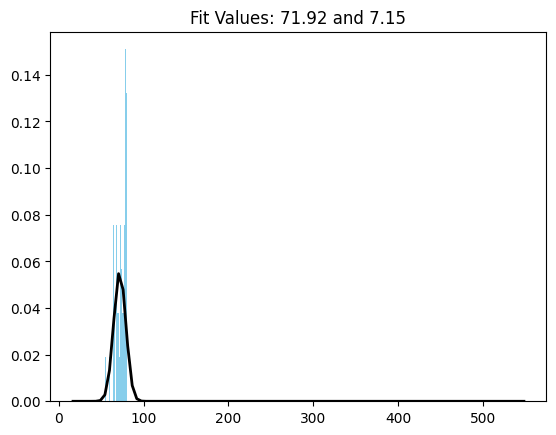

In [7]:
import scipy.stats as stats
# try to fit normal distribution
points_data = points_per_trip['count']
points_data = points_data[points_data < 80].values # manually remove outliers. Is this cheating?
mu, std = stats.norm.fit(points_data)

plt.hist(points_data, 
         bins=range(min(points_per_trip['count']), max(points_per_trip['count']) + 1, 1),
         density=True,
         color='skyblue'
         )

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)

In [8]:
# Calculate x and y components of speed starting from known values of SOG and COG
# System of equations (as written in the paper): 1) SOG^2 = Vx^2 + Vy^2, 2) COG = arctan((Vy)/(Vx))
# For equation #2, there is an issue as arctan is hard to invert. So instead of using this system of equations, we can use another one:
# New system of equations: 1) Vx = SOG * cos(COG), 2) Vy = SOG * sin(COG)

# First step: convert true north COG angles into standard arithmetic angles.
# Formula: X = (450 - COG) mod 360 
# https://community.safe.com/general-10/how-to-convert-arithmetic-angles-to-geographic-angles-18164

myDF['A_COG'] = (450 - myDF['COG']) % 360
display(myDF['A_COG'].head(3))
# convert the arithmetic angles in radians
myDF['A_COG'] = myDF['A_COG'].apply(radians)
display(myDF['A_COG'].head(3))
# calculate Vx and Vy
myDF['V_x'] = myDF['SOG'] * np.cos(myDF['A_COG'])
myDF['V_y'] = myDF['SOG'] * np.sin(myDF['A_COG'])
display(myDF[['V_x', 'V_y']].head(3))

# compare with points on map:
plot = f.route_arrows_plot(inputDF=myDF.head(3).copy(), color_criteria='Avg_Speed', scale_factor=0.0001)
po.plot(plot, auto_open=True)

0    113.0
1     20.0
2    252.0
Name: A_COG, dtype: float64

0    1.972222
1    0.349066
2    4.398230
Name: A_COG, dtype: float64

,V_x,V_y
0,-0.547024,1.288707
1,0.751754,0.273616
2,-0.679837,-2.092324


'temp-plot.html'

In [9]:
# Divide the dataset in train and test

# Select supposedly good trips to use as "normal" behaviour -> train dataset
points_per_trip.sort_values(by="count", ascending=True, inplace=True)

# Supposedly Good Trips (save the IDs)
train_ids = pd.Series(name="trip_id") # new empty Series
# coefficient used to separate train dataset from test dataset
GT_COEFF = 0.7 # G.T. = "Good Trips"
# Fill the Series with the "trip_id" of the first (GT_COEFF)% of trips (ordered from shortest to longest)
train_ids = points_per_trip.iloc[0:int(len(points_per_trip) * GT_COEFF), 0]
test_ids = set(points_per_trip["trip_id"]).difference(train_ids)

try: # quick check
    assert len(train_ids) + len(test_ids) == len(points_per_trip)
except AssertionError:
    print(f"Error: {len(train_ids)} + {len(test_ids)} should be equal to {len(points_per_trip)}. Values not matching")

# Create a new DF with the full data of the selected trips
train_DF = myDF[myDF['trip_id'].isin(train_ids)]
test_DF = myDF[myDF['trip_id'].isin(test_ids)]

# quick check: from a groupby (on trip_id) of train_df I expect the number of rows to be equal to the len of train_ids
test_delete = train_DF.groupby(by="trip_id")
try:
    assert len(train_ids) == len(test_delete), "Should be the same length"
except AssertionError:
    print(f"Error: {len(train_ids)} should be equal to {len(test_delete)}. Values not matching")
del test_delete

plot = f.route_arrows_plot(inputDF=train_DF, color_criteria='Avg_Speed', scale_factor=0.0001, title=f'Train dataset (coeff: {GT_COEFF}) of Route {train_DF.iloc[0, train_DF.columns.get_loc("Route")]}')
po.plot(plot, auto_open=True)

plot = f.route_arrows_plot(inputDF=test_DF, color_criteria='Avg_Speed', scale_factor=0.0001, title=f'Test dataset (coeff: {round(1-GT_COEFF, 1)}) of Route {train_DF.iloc[0, train_DF.columns.get_loc("Route")]}')
po.plot(plot, auto_open=True)

'temp-plot.html'

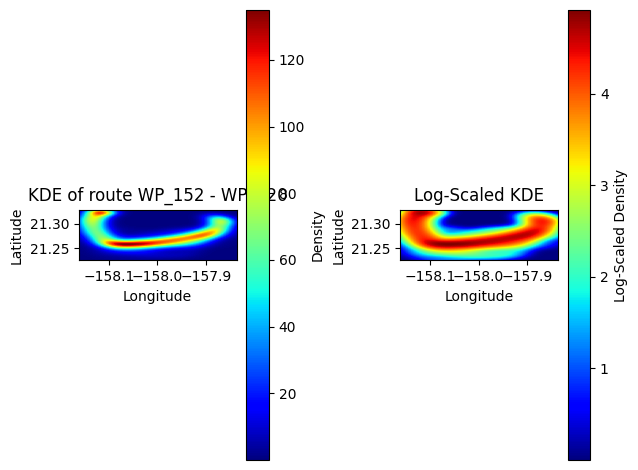

In [10]:
from scipy.stats import gaussian_kde

# Perform KDE on LON,LAT pairs (respectively x,y). See paper (page 2236, equation 8)
x = train_DF['LON']
y = train_DF['LAT']

kde = gaussian_kde([x,y])
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

# create a grid of points
x_grid, y_grid = np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100)
X, Y = np.meshgrid(x_grid, y_grid)
positions = np.vstack([X.ravel(), Y.ravel()])
# Z is a matrix that contains the estimated density values at each grid point
# defined by x_grid and y_grid
Z = np.reshape(kde(positions).T, X.shape)

# plot kde result on map
fig, axes = plt.subplots(1,2)
im1 = axes[0].imshow(
    Z,
    origin='lower',
    #aspect='auto',
    extent=[xmin, xmax, ymin, ymax],
    cmap='jet'
)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title(f'KDE of route {myDF.at[0, "Route"]}')
fig.colorbar(im1, ax=axes[0], label="Density")

# Show normalized scale
Z_log = np.log1p(Z)
im2 = axes[1].imshow(Z_log,
            origin='lower',
            #aspect='auto',
            extent=[xmin, xmax, ymin, ymax],
            cmap='jet'
           )
axes[1].set_title('Log-Scaled KDE')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
fig.colorbar(im2, ax=axes[1], label="Log-Scaled Density")

plt.tight_layout()
plt.show()

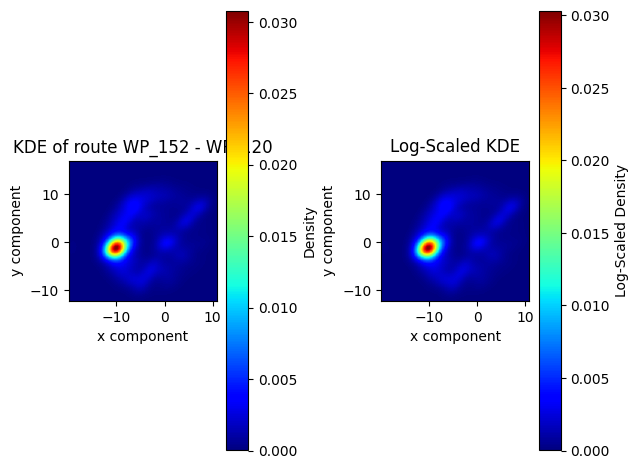

In [14]:
# Perform KDE on speed components (respectively V_x, V_y). See paper (page 2236, equation 8)
V_x = train_DF['V_x']
V_y = train_DF['V_y']

kde = gaussian_kde([V_x,V_y])
Vxmin, Vxmax = V_x.min(), V_x.max()
Vymin, Vymax = V_y.min(), V_y.max()

# create a grid of points
Vx_grid, Vy_grid = np.linspace(Vxmin, Vxmax, 100), np.linspace(Vymin, Vymax, 100)
V_X, V_Y = np.meshgrid(Vx_grid, Vy_grid)
positions = np.vstack([V_X.ravel(), V_Y.ravel()])
# Z is a matrix that contains the estimated density values at each grid point
# defined by x_grid and y_grid
V_Z = np.reshape(kde(positions).T, V_X.shape)

# plot kde result on map
fig, axes = plt.subplots(1,2)
im1 = axes[0].imshow(
    V_Z,
    origin='lower',
    #aspect='auto',
    extent=[Vxmin, Vxmax, Vymin, Vymax],
    cmap='jet'
)
axes[0].set_xlabel('x component')
axes[0].set_ylabel('y component')
axes[0].set_title(f'KDE of route {myDF.at[0, "Route"]}')
fig.colorbar(im1, ax=axes[0], label="Density")

# Show normalized scale
# this is done just in case the data is skewed. When the data is not skewed, this whole operation
# doesn't affect the plot by much, if at all
VZ_log = np.log1p(V_Z) 
im2 = axes[1].imshow(VZ_log,
            origin='lower',
            #aspect='auto',
            extent=[Vxmin, Vxmax, Vymin, Vymax],
            cmap='jet'
           )
axes[1].set_title('Log-Scaled KDE')
axes[1].set_xlabel('x component')
axes[1].set_ylabel('y component')
fig.colorbar(im2, ax=axes[1], label="Log-Scaled Density")

plt.tight_layout()
plt.show()

array([[-157.8744, -157.8727, -157.8693, ..., -158.1158, -158.1154,
        -158.1151],
       [  21.31  ,   21.3086,   21.3042, ...,   21.3227,   21.3223,
          21.3221]])

(2, 11260)

(11260,)

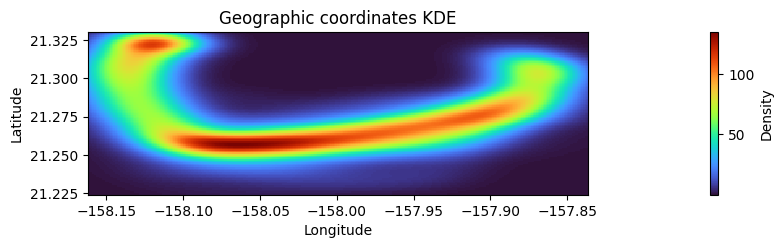

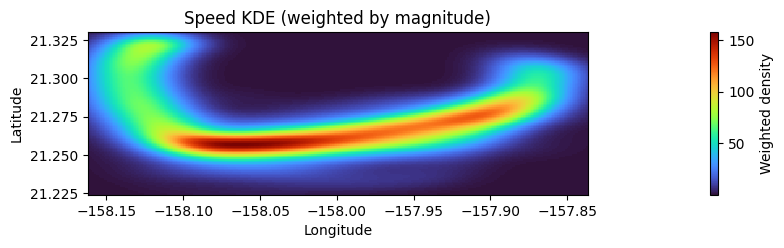

In [28]:
# Extract grid ranges
lon_min, lon_max = train_DF['LON'].min(), train_DF['LON'].max()
lat_min, lat_max = train_DF['LAT'].min(), train_DF['LAT'].max()

# keep same aspect ration
lon_range = lon_max - lon_min
lat_range = lat_max - lat_min
aspect_ratio = lon_range / lat_range

n_points = 100 
lon_points = int(n_points * aspect_ratio)
lat_points = n_points
    
# Create the actual grid
lon_grid = np.linspace(lon_min, lon_max, lon_points) # create equally spaced points from lon_min to lon_max
lat_grid = np.linspace(lat_min, lat_max, lat_points)
LON, LAT = np.meshgrid(lon_grid, lat_grid)

# Calculate KDE using LAT, LON values
positions = np.vstack([LON.ravel(), LAT.ravel()])
values = np.vstack([train_DF['LON'], train_DF['LAT']])
kernel_geo = gaussian_kde(values)
Z_geo = np.reshape(kernel_geo(positions), LON.shape)

# Calculate KDE using V_x, V_y values
# Geographical coordinates are weighted using the magnitude of the vector V
values_v = np.vstack([train_DF['LON'], train_DF['LAT']])
display(values_v)
display(values_v.shape)
display(train_DF['SOG'].shape)
kernel_v = gaussian_kde(values_v, weights=train_DF['SOG'])
Z_v = np.reshape(kernel_v(positions), LON.shape)

# Calculate size of the plot in order to keep the aspect ratio
base_size = 8
fig_width = base_size * aspect_ratio if aspect_ratio > 1 else base_size
fig_height = base_size / aspect_ratio if aspect_ratio > 1 else base_size
    
# Plot in separate figures
# KDE of LAT,LON values
fig1 = plt.figure(figsize=(fig_width, fig_height))
ax1 = fig1.add_subplot(111) #111 -> 1 row, 1 column, index of the current subplot
im1 = ax1.pcolormesh(LON, LAT, Z_geo, shading='auto', cmap='turbo') # pseudocolor plot with non-regular grid (makes the plt rectangular instead of squared)
ax1.set_title('Geographic coordinates KDE')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_aspect('equal')  # Sets the correct aspect ratio
plt.colorbar(im1, ax=ax1, label='Density')
plt.tight_layout() # automatically adjust subplot size so that it fits its area

# KDE of speed vectors
fig2 = plt.figure(figsize=(fig_width, fig_height))
ax2 = fig2.add_subplot(111)
im2 = ax2.pcolormesh(LON, LAT, Z_v, shading='auto', cmap='turbo') # alternativa colormaps: 'rainbow, gist_rainbow'
ax2.set_title('Speed KDE (weighted by magnitude)')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_aspect('equal')
plt.colorbar(im2, ax=ax2, label='Weighted density')
plt.tight_layout()

plt.show()

In [ ]:
# Calculate product between Spatial KDE and Speed KDE (see equation 8 page 2236)
Z_product = Z_geo * Z_v
try:
    assert (Z_product.shape == Z_geo.shape) and (Z_product.shape == Z_v.shape)
except AssertionError:
    print("The final matrix should have the same shape of the starting matrices")